# AS5001 (SUPA-AAA) Advanced (Astronomical) Data Analysis

## Project 2: Deadline 5 pm Wed 23 Nov 2022

## Hunting a Black Hole in GS2000

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import os
import glob
from matplotlib import cm
from scipy import signal

1: Plot on a single page the template star spectra, arranged by spectral
type, and normalised to a common continuum level, to show how absorption line
ratios change with spectral type. [5]

In [2]:
spectypes = ['g5', 'g9', 'k0', 'k1', 'k2', 'k4', 'k5', 'k7', 'k8', 'm0']
files = glob.glob('keck/keck_??.dat')
template = {}
for i, file in enumerate(sorted(files)):
    template[spectypes[i]] = pd.read_csv(file, delim_whitespace=True, names=["wl", "flux", "uncert"])

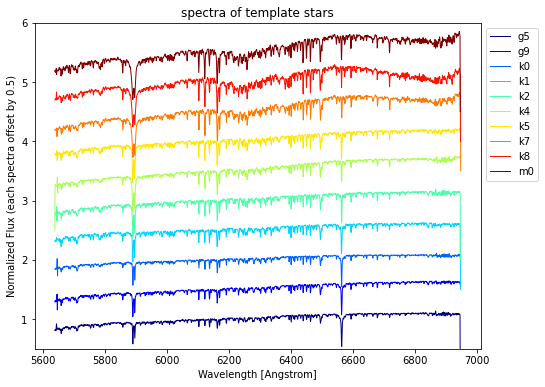

In [40]:
plt.figure(figsize=(8,6))
colors = [cm.jet(x) for x in np.linspace(0, 1, len(spectypes))]
for i, spectype in enumerate(spectypes):
    plt.plot(template[spectype]["wl"], template[spectype]["flux"]/np.median(template[spectype]["flux"]) + 0.5*i, 
        color=colors[i], linewidth=1, label=spectypes[i])
plt.ylim(0.5,6)
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Normalized Flux (each spectra offset by 0.5)")
plt.title("spectra of template stars")
plt.show()

2: Plot on a single page, ordered by binary phase, the 13 spectra of GS2000,
to show the shape of the continuum and the changing profile of the H-alpha
emission line. [5]

In [284]:
files = glob.glob('keck/keck_gs2000_??.dat')
data = {}
for i, file in enumerate(sorted(files)):
    phase = file[-6:-4]
    data[phase] = pd.read_csv(file, delim_whitespace=True, names=["wl", "flux", "uncert"])
epochs = list(data.keys())

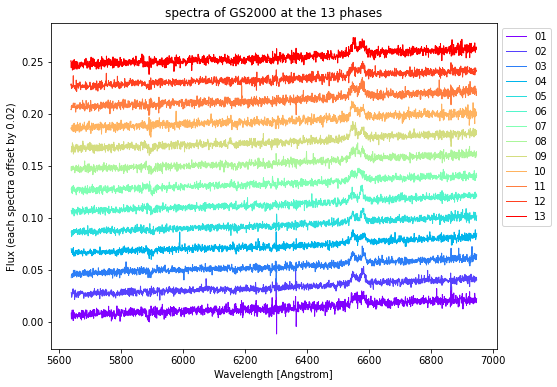

In [41]:
plt.figure(figsize=(8,6))
colors = [cm.rainbow(x) for x in np.linspace(0, 1, len(epochs))]
for i, epoch in enumerate(epochs):
    plt.plot(data[epoch]["wl"], data[epoch]["flux"]+ 0.02*i, 
        color=colors[i], linewidth=1, label=epochs[i])
#plt.ylim(0.5,6)
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Flux (each spectra offset by 0.02)")
plt.title("spectra of GS2000 at the 13 phases")
plt.show()

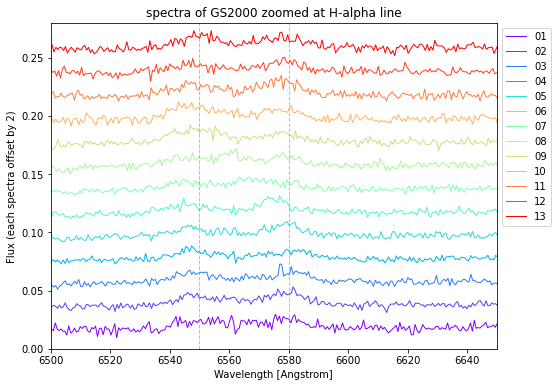

In [42]:
plt.figure(figsize=(8,6))
colors = [cm.rainbow(x) for x in np.linspace(0, 1, len(epochs))]
for i, epoch in enumerate(epochs):
    plt.plot(data[epoch]["wl"], data[epoch]["flux"] + 0.02*i, 
        color=colors[i], linewidth=1, label=epochs[i])
plt.ylim(0,0.28)
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.axvline(6550,color='grey',alpha=0.5,linewidth=1,linestyle='--')
plt.axvline(6580,color='grey',alpha=0.5,linewidth=1,linestyle='--')
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Flux (each spectra offset by 2)")
plt.title("spectra of GS2000 zoomed at H-alpha line")
plt.xlim(6500, 6650)
plt.show()

3: Plot the average of the 13 spectra of GS2000.
Are any of the expected absorption lines detected?
What range of spectral types provides a good match? [5]

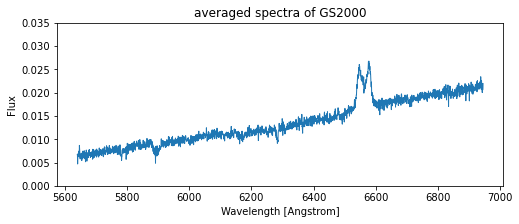

In [173]:
fluxes = np.vstack([data[epoch]["flux"] for epoch in epochs])
fluxes_avg = np.mean(fluxes, axis=0)
plt.figure(figsize=(8,3))
plt.plot(data["01"]["wl"], fluxes_avg, linewidth=1)
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Flux")
plt.ylim((0, 0.035))
plt.title("averaged spectra of GS2000")
plt.show()

**ANS**: We detected an abosrption line roughly at 5900 Angstrom, with correspond to the Sodium D lines in the K stars. The spectral types k1-k5 provide a good match by looking at the shape of continuum.

4: Fit a smooth function to the continuum of each of the spectra.
Plot the average GS2000 spectrum divided by the fitted continuum,
and do the same for the most suitable template spectrum. [10]

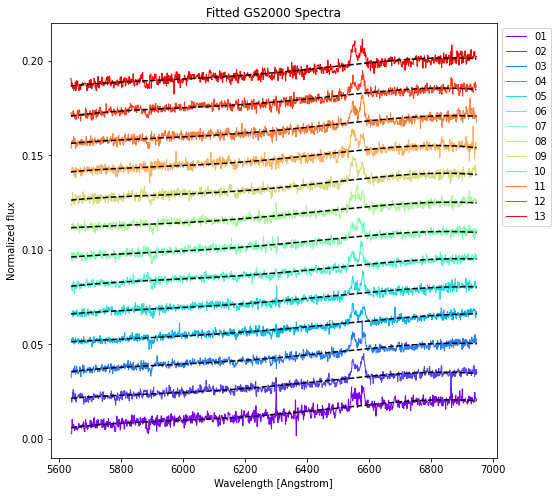

In [174]:
plt.figure(figsize=(8, 8))
colors = [cm.rainbow(x) for x in np.linspace(0, 1, len(epochs))]
continuums = np.zeros(fluxes.shape)
for i, epoch in enumerate(epochs):
    wl = data[epoch]["wl"]
    flux = signal.medfilt(data[epoch]["flux"], 3)
    #flux = data[epoch]["flux"]
    coeffs = np.polyfit(wl, flux, deg=4)
    f = np.poly1d(coeffs)
    fitted_flux = f(wl)
    continuums[i,:] = fitted_flux
    plt.plot(wl, flux + 0.015*i, color=colors[i], linewidth=1, label=epochs[i])
    plt.plot(wl, fitted_flux + 0.015*i, "--", color="k", linewidth=1.5)
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.ylim(-0.01, 0.22)
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Normalized flux")
plt.title("Fitted GS2000 Spectra")
plt.show()

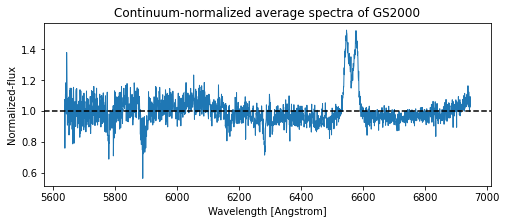

In [97]:
norm_fluxes = fluxes/continuums
norm_fluxes_avg = np.mean(norm_fluxes, axis=0)
plt.figure(figsize=(8,3))
plt.plot(data["01"]["wl"], norm_fluxes_avg, linewidth=1)
plt.axhline(1.0, ls="--", color="k", linewidth=1.5)
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Normalized-flux")
plt.title("Continuum-normalized average spectra of GS2000")
plt.show()

Finding the most suitable template:

In [98]:
def chi_square(data, model, error):
    return np.sum((data - model)**2 / error**2)

errors = np.vstack([data[epoch]["uncert"] for epoch in epochs])
errors_avg = np.mean(errors, axis=0)
res = []
for spectype in spectypes:
    temp = template[spectype]["flux"]
    chisq = chi_square(norm_fluxes_avg, temp, errors_avg)
    res.append((spectype,chisq))
print(f"The best fitting stellar type is {sorted(res, key=lambda x:x[1])[0][0]}.")

The best fitting stellar type is k5.


Plot k5 spectrum divided by the fitted continuum

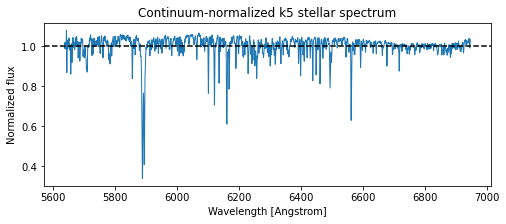

In [175]:
spectype= "k5"
coeffs_temp = np.polyfit(template[spectype]["wl"], template[spectype]["flux"], deg=4)
f = np.poly1d(coeffs_temp)
fitted_temp = f(template[spectype]["wl"])
norm_temp = template[spectype]["flux"]/fitted_temp
plt.figure(figsize=(8,3))
plt.plot(template[spectype]["wl"], norm_temp, linewidth=1)
plt.axhline(1.0, ls="--", color="k", linewidth=1.5)
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Normalized flux")
plt.title("Continuum-normalized k5 stellar spectrum")
plt.show()

5: For each of the 13 spectra, measure the radial velocity by
performing a cross-correlation analysis with the most suitable
template spectrum. [25]

To accomplish this:
    
(a) Subtract the continuum from the GS2000 spectrum,
and from the template spectra.

In [188]:
fluxes_ = fluxes - continuums
#fluxes_ /= np.max(np.abs(fluxes_))
temp_ = template[spectype]["flux"] - fitted_temp
#temp_ /= np.max(np.abs(temp_))

(b) Apply a velocity shift to the continuum-subtracted
template spectrum.

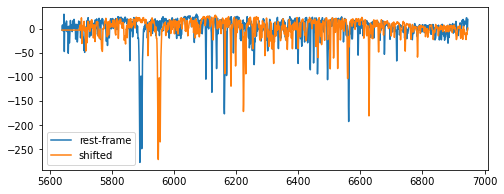

In [189]:
def doppler_shift(wl, v):
    c = 2.998e5 # km/s
    wl_shifted = wl*(1 + (v/c))
    return wl_shifted

wl_temp = template[spectype]["wl"]

v = 3000  # km/s
wl_temp_shifted = doppler_shift(wl_temp, v)
plt.figure(figsize=(8,3))
plt.plot(wl_temp, temp_, label="rest-frame")
plt.plot(wl_temp, np.interp(wl_temp, wl_temp_shifted, temp_), label="shifted")
plt.legend()
plt.show()

(c) Scale the shifted and continuum-subtracted template
spectrum to fit the continuum-subtracted GS2000 spectrum.

(d) Repeat the above for a number of different velocities,
and plot the $\chi^2$ of the fit as a function of 
the velocity shift.

In [227]:
def optimal_scaling_factor(data, pattern, error):
    scale = np.sum((data*pattern) / error**2) / np.sum((pattern/error)**2)
    var = 1. / np.sum((pattern/error)**2)
    return scale, var

velos = np.linspace(-999, 1000, num=2000)
ccfs = np.zeros((len(epochs), len(velos)))
var_ccfs = np.zeros((len(epochs), len(velos)))
chisqs = np.zeros((len(epochs), len(velos)))

for i, epoch in enumerate(epochs):
    for j, v in enumerate(velos):
        wl_temp_shifted = doppler_shift(wl_temp, v)
        temp_shifted = np.interp(data[epoch]["wl"], wl_temp_shifted, temp_)
        ccf, var_ccf = optimal_scaling_factor(fluxes_[i], temp_shifted, errors[i])
        model = temp_shifted * ccf
        chisq = chi_square(fluxes_[i], model, errors[i])
        ccfs[i, j] = ccf
        var_ccfs[i, j] = var_ccf
        chisqs[i, j] = chisq

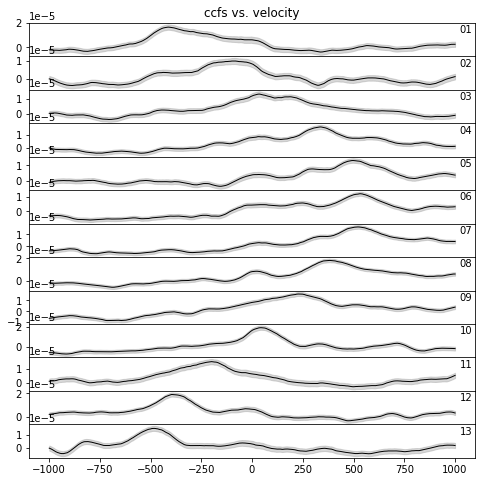

In [229]:
# Plot the ccfs vs. velocity and their uncertainties
plt.figure(figsize=(8,8))
plt.subplots_adjust(hspace=0)
for i, epoch in enumerate(epochs):
    plt.subplot(13, 1, i+1)
    plt.plot(velos, ccfs[i], linewidth=1, color='k')
    plt.fill_between(velos, ccfs[i]+np.sqrt(var_ccfs[i]), ccfs[i]-np.sqrt(var_ccfs[i]), alpha=0.3, color="grey")
    plt.text(0.965,0.7,epoch, transform=plt.gca().transAxes)
    plt.title("ccfs vs. velocity") if i==0 else None

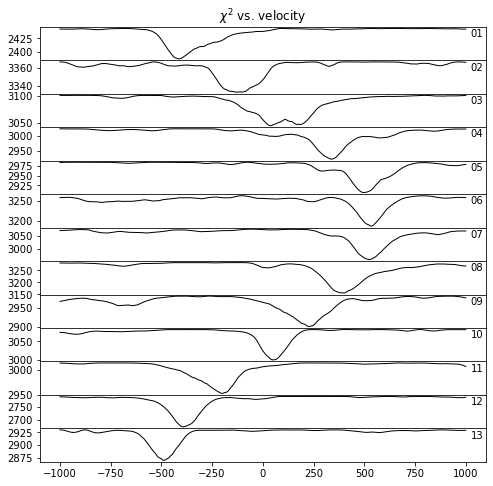

In [230]:
# Plot the chisqs vs. velocity
plt.figure(figsize=(8,8))
plt.subplots_adjust(hspace=0)
for i, epoch in enumerate(epochs):
    plt.subplot(13, 1, i+1)
    plt.plot(velos, chisqs[i], linewidth=1, color='k')
    plt.text(0.965,0.7,epoch, transform=plt.gca().transAxes)
    plt.title("$\chi^2$ vs. velocity") if i==0 else None

(e) Use the $\chi^2$ minimum to estimate the radial velocity
and its 1-sigma uncertainty.

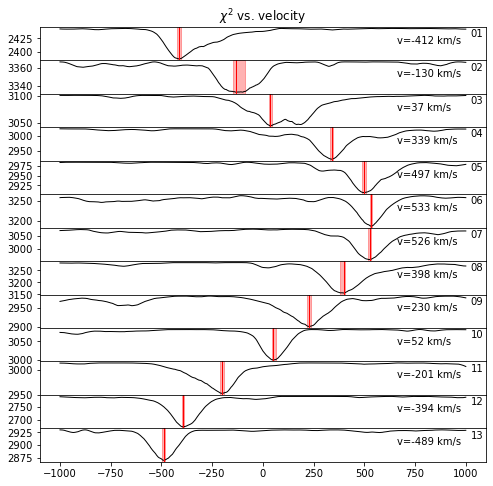

In [283]:
velos_fitted = np.zeros(len(epochs))
velos_upper = np.zeros(len(epochs))
velos_lower = np.zeros(len(epochs))
for i, epoch in enumerate(epochs):
    chisqmin = np.min(chisqs[i])
    velos_idx = np.where(chisqs[i]==chisqmin)
    onesig_idx = np.where(chisqs[i]<=chisqmin+1.) # delta_chisq=1 give 1-sig error bars
    velos_fitted[i] = velos[velos_idx][0]
    velos_upper[i] = velos[onesig_idx][-1]
    velos_lower[i] = velos[onesig_idx][0]
    #print(lower, upper)

# Plot the chisqs with uncertainty
plt.figure(figsize=(8,8))
plt.subplots_adjust(hspace=0)
for i, epoch in enumerate(epochs):
    plt.subplot(13, 1, i+1)
    plt.plot(velos, chisqs[i], linewidth=1, color='k')
    plt.axvline(velos_fitted[i], color="r", linewidth=1)
    plt.axvspan(velos_lower[i], velos_upper[i], color="r", alpha=0.3)
    plt.text(0.965,0.7,epoch, transform=plt.gca().transAxes)
    plt.text(0.8, 0.5, f"v={velos_fitted[i]:.0f} km/s", transform=plt.gca().transAxes)
    plt.title("$\chi^2$ vs. velocity") if i==0 else None

6: Plot the measured velocities and 1-sigma uncertainties
as a function of binary phase. Put these results also 
in a table in your report. [5]

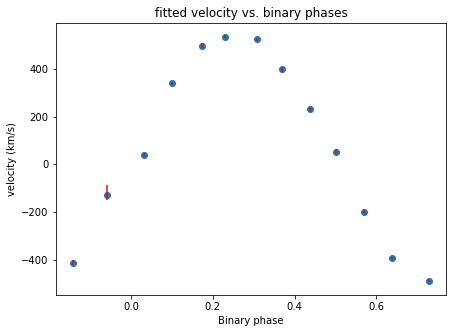

In [335]:
phases = [-0.1405, -0.0583, 0.0325, 0.0998, 0.1740, 0.2310, 0.3079, 0.3699, 0.4388, 0.5008, 0.5698, 0.6371, 0.7276]
plt.figure(figsize=(7,5))
plt.errorbar(phases, velos_fitted, [velos_fitted-velos_lower, velos_upper-velos_fitted], 
    fmt='o', ecolor='r', barsabove=True)
plt.xlabel("Binary phase")
plt.ylabel("velocity (km/s)")
plt.title("fitted velocity vs. binary phases")
plt.show()

table = {
    "bphase": phases,
    "velocity": velos_fitted,
    "error_lower": velos_fitted-velos_lower,
    "error_upper": velos_upper-velos_fitted,
}
df = pd.DataFrame(table)
df.to_csv("fitted_velocity_table.csv")

7: Fit a sinusoidal velocity curve of the form
$$
V(\phi) = \gamma + K_x  \sin{( 2\,\pi\,\phi)} + K_y 
\cos{(2\,\pi\,\phi)}
$$
to the 13 velocity measurements. Show the best fit velocity curve
on your plot with the data points and error bars. [5]

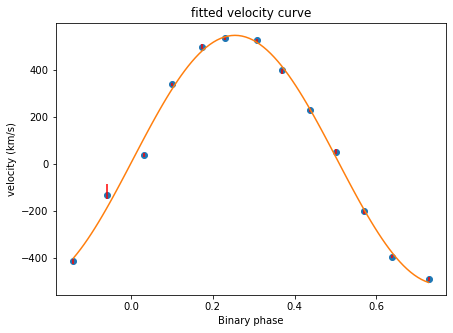

In [343]:
from scipy.optimize import curve_fit
def sinusoidal(phi, gamma, Kx, Ky):
    return gamma + Kx * np.sin(2*np.pi*phi) + Ky * np.cos(2*np.pi*phi)

fit = curve_fit(sinusoidal, phases, velos_fitted)
gamma, Kx, Ky = fit[0]
pcov = np.sqrt(np.diag(fit[1]))
Kxerr, Kyerr = pcov[1:3]

plt.figure(figsize=(7,5))
plt.errorbar(phases, velos_fitted, [velos_fitted-velos_lower, velos_upper-velos_fitted], 
    fmt='o', ecolor='r', barsabove=True)
x = np.linspace(phases[0], phases[-1], 100)
plt.plot(x, sinusoidal(x, gamma, Kx, Ky), color="tab:orange")
plt.xlabel("Binary phase")
plt.ylabel("velocity (km/s)")
plt.title("fitted velocity curve")
plt.show()

8: From your results, estimate the radial velocity semi-amplitude,
$	K = \left( {K_x}^2 + {K_y}^2 \right)^{1/2} $
	and its 1-$\sigma$ uncertainty.
	This is the orbit velocity of the companion star,
	projected by a factor $\sin{\left(i\right)}$ due to the inclination of 
the orbit. Describe your algorithm clearly and without unambiguity. [10]

**ANS**: The uncertainty in $K$, is calculated by the propagation of error, assuming $K_x$ and $K_y$ are independent random variables:

$K_\text{err} = \sqrt{(\frac{\partial K}{\partial K_x} \cdot K_\text{x, err})^2 + (\frac{\partial K}{\partial K_y} \cdot K_\text{y, err})^2} = \sqrt{(K_x^2 + K_y^2)^{-1}(K_x^2K_\text{x, err}^2 + K_y^2K_\text{y, err}^2)}$

In [346]:
K = np.sqrt(Kx**2 + Ky**2)
Kerr = np.sqrt((Kx**2 + Ky**2)**(-1)*(Kx**2*Kxerr**2 + Ky**2*Kyerr**2))
print(f"The measured orbit velocity of the companion star is {K:.2f} ± {Kerr:.2f} km/s.")

The measured orbit velocity of the companion star is 528.12 ± 13.51 km/s.


9: Give two expressions for the compact object mass function $f(M_x)$,
the first in terms of the observable quantities $P$ and $K$,
and the second in terms of the compact object mass $M_x$,
the inclination $i$, and the mass ratio $q=M_c/M_x$, where $M_c$ is
the companion star mass.
From the binary period $P$ and your measured $K$ velocity,
estimate $f(M_x)$ in solar units.
Give also the 1-sigma uncertainty. [5]

**ANS**: The compact object mass function is given by:

$f(M_x) = \frac{K^3 P}{2 \pi G} = \frac{M_x(\sin{i})^3}{(1+q)^2}$

The binary period is $P = 0.3440915 ± 0.0000001$ days from the notes. With measured $K=528.12 ± 13.51$ km/s, we can calculate the estimate of $f(M_x)$.

The uncetainty in $f(M_x)$ is once again computed using error propagation, again assuming independent and random uncertainties in $P$ and $K$, yielding the following expression:

$f(M_x)_\text{err} = \sqrt{(\frac{\partial f(M_x)}{\partial K} \cdot K_\text{err})^2 + (\frac{\partial f(M_x)}{\partial P} \cdot P_\text{err})^2} = \sqrt{(\frac{3K^2 P}{2 \pi G} \cdot K_\text{err})^2 + (\frac{K^3}{2 \pi G} \cdot P_\text{err})^2}$

10: Adopt a specific inclination $i=90^\circ$,
and a specific $M_c=0.5~M_\odot$.
For these choices, calculate the compact
object mass $M_x$. Give the 1-$\sigma$ uncertainty, assuming that 
$i$ and $M_c$ are known exactly.
Be clear about your algorithm for estimating the uncertainties,
and collect your results in a table in your report. [5]

11: In fact $i$ and $M_c$ are not known, but have some limited range.
What range of $i$ and $M_c$ would be appropriate, given what
you know about the spectral type of the donor star, and
considering that no eclipses occur?
Use Monte-Carlo error propogation to sample the range of uncertainty
in $i$, $M_c$, $K$, and $P$.  Be careful to assume a distribution 
for $i$ that corresponds to a random orbit orientation.
For each Monte-Carlo trial, calculate
the corresponding $M_x$.  Make plots showing the resulting
probability distribution for $M_x$, both as a probability density
histogram, and as a cumulative probability function.
Draw vertical lines on the plots to indicate
the mean and median of the $M_x$ distribution,
and a 1-sigma confidence interval for $M_x$.
As always, be clear in describing your algorithms.
Collect your results in a table in your report. [15]

12: Give the probability that the compact object mass is higher
than 3 solar masses, and hence the probability that it
is a black hole rather than a neutron star. [5]